# Negation signal - withOUT bag of words
## Loading dataset

In [16]:
from datetime import datetime
from negation_signal_common import create_semi_dataset, create_vectorizer, create_columns_names
from negation_signal_common import create_features_list, save_to_csv
from utils import get_datasets


def create_dataset(dataset, sufix):
    ouput_name = '{}.csv'.format(dataset[:-4])
    print('{} START Creating semi dataset {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))
    X_train, X_test = create_semi_dataset(dataset)
    vect_lemma = create_vectorizer(X_train)
    column_names = create_columns_names(X_train, vect_lemma, add_bow=False)
    print('{} START Creating features list {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))
    X_train_features_list = create_features_list(X_train, vect_lemma, add_bow=False)
    X_test_features_list = create_features_list(X_test, vect_lemma, add_bow=False)
    print('{} START Save csv {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))
    save_to_csv(ouput_name + sufix + '-train', column_names, X_train_features_list)
    save_to_csv(ouput_name + sufix + '-test', column_names, X_test_features_list)
    print('{} START Save csv {}'.format(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), dataset))


for dataset in get_datasets():
    create_dataset(dataset, '-sig')

2017-05-02 19:19:18 START Creating semi dataset dataset/beletria/merged.xml
2017-05-02 19:19:18 START Creating features list dataset/beletria/merged.xml


2017-05-02 19:20:01 START Save csv dataset/beletria/merged.xml


2017-05-02 19:20:04 START Save csv dataset/beletria/merged.xml
2017-05-02 19:20:04 START Creating semi dataset dataset/recenzie/merged.xml


2017-05-02 19:20:05 START Creating features list dataset/recenzie/merged.xml


2017-05-02 19:20:59 START Save csv dataset/recenzie/merged.xml


2017-05-02 19:21:02 START Save csv dataset/recenzie/merged.xml
2017-05-02 19:21:02 START Creating semi dataset dataset/snk/merged.xml
2017-05-02 19:21:03 START Creating features list dataset/snk/merged.xml


2017-05-02 19:21:21 START Save csv dataset/snk/merged.xml


2017-05-02 19:21:23 START Save csv dataset/snk/merged.xml
2017-05-02 19:21:23 START Creating semi dataset dataset/sport/merged.xml


2017-05-02 19:21:23 START Creating features list dataset/sport/merged.xml


2017-05-02 19:22:24 START Save csv dataset/sport/merged.xml


2017-05-02 19:22:29 START Save csv dataset/sport/merged.xml


2017-05-02 19:22:29 START Creating semi dataset dataset/vlastne_mario/merged.xml
2017-05-02 19:22:29 START Creating features list dataset/vlastne_mario/merged.xml


2017-05-02 19:22:31 START Save csv dataset/vlastne_mario/merged.xml
2017-05-02 19:22:31 START Save csv dataset/vlastne_mario/merged.xml


In [2]:
create_dataset('dataset/snk/merged.xml', '-sig')

2017-05-02 19:01:43 START Creating semi dataset dataset/snk/merged.xml
2017-05-02 19:01:43 START Creating features list dataset/snk/merged.xml


2017-05-02 19:02:06 START Save csv dataset/snk/merged.xml


2017-05-02 19:02:08 START Save csv dataset/snk/merged.xml


## Training

In [2]:
%%time
from negation_common import load_dataset

df_train, df_test, df2_train, df2_test = load_dataset('dataset/snk/merged.csv', 
                                                      '-sig', 
                                                      ['token', 'lemma', 'POS', 'is_negation'])

CPU times: user 378 ms, sys: 61.6 ms, total: 440 ms
Wall time: 528 ms


In [6]:
%%time
# Import Library of Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# model = MultinomialNB()
# model = GaussianNB()
# model = BernoulliNB()
# model = SVC()
model = RandomForestClassifier()

# Train the model using the training sets 
model.fit(df2_train, df_train.is_negation)

CPU times: user 207 ms, sys: 11.6 ms, total: 219 ms
Wall time: 240 ms


## Metrics

In [7]:
from utils import print_score_for

y_true, y_pred = print_score_for(model, df2_test, y_true=df_test.is_negation)

Accuracy: 0.9890992541594952
Precision: 0.974025974025974
Recall: 0.8152173913043478
F1 score: 0.8875739644970413
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1651
          1       0.97      0.82      0.89        92

avg / total       0.99      0.99      0.99      1743



In [16]:
from utils import show_roc_curve

fig = show_roc_curve(y_true, y_pred)

In [18]:
fig.savefig('images/test.svg')

dataset/beletria/merged.xml


Accuracy: 0.9953025697706549
Precision: 0.9253731343283582
Recall: 0.8378378378378378
F1 score: 0.8794326241134752
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      3545
          1       0.93      0.84      0.88        74

avg / total       1.00      1.00      1.00      3619



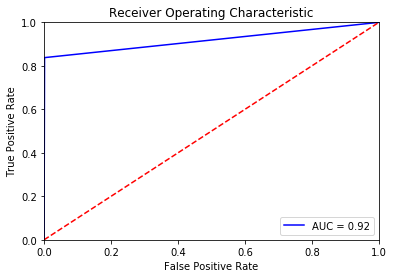

dataset/recenzie/merged.xml


Accuracy: 0.9932899552663684
Precision: 0.8823529411764706
Recall: 0.625
F1 score: 0.7317073170731708
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      4846
          1       0.88      0.62      0.73        72

avg / total       0.99      0.99      0.99      4918



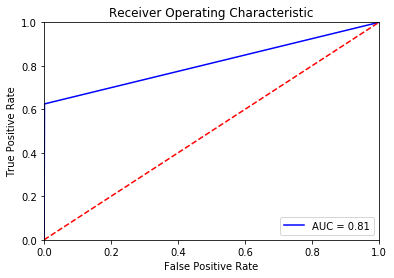

dataset/snk/merged.xml


Accuracy: 0.9890992541594952
Precision: 0.974025974025974
Recall: 0.8152173913043478
F1 score: 0.8875739644970413
             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1651
          1       0.97      0.82      0.89        92

avg / total       0.99      0.99      0.99      1743



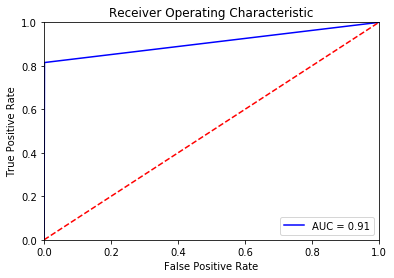

dataset/sport/merged.xml


Accuracy: 0.9961685823754789
Precision: 0.8717948717948718
Recall: 0.85
F1 score: 0.8607594936708861
             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5662
          1       0.87      0.85      0.86        80

avg / total       1.00      1.00      1.00      5742



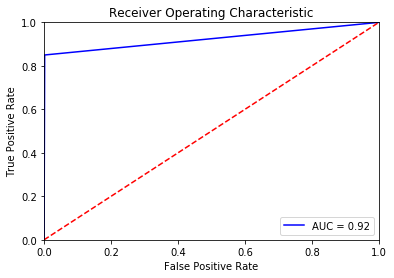

dataset/vlastne_mario/merged.xml
Accuracy: 0.9337748344370861
Precision: 1.0
Recall: 0.4444444444444444
F1 score: 0.6153846153846153
             precision    recall  f1-score   support

          0       0.93      1.00      0.96       133
          1       1.00      0.44      0.62        18

avg / total       0.94      0.93      0.92       151



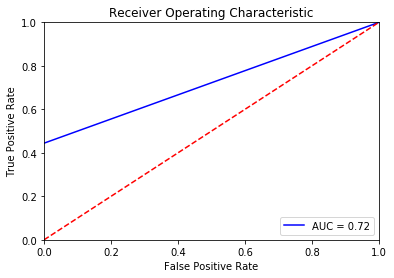

In [21]:
import pickle
from utils import get_datasets, print_score_for, show_roc_curve
from negation_common import load_dataset

with open('model-forest-sig.pkl', 'rb') as f:
    model = pickle.load(f)

sufix = '-sig'
for dataset in get_datasets():
    print('============================================')
    print(dataset)
    df_train, df_test, df2_train, df2_test = load_dataset(dataset, 
                                                          sufix, 
                                                          ['token', 'lemma', 'POS', 'is_negation'])
    y_true, y_pred = print_score_for(model, df2_test, y_true=df_test.is_negation)
    plot = show_roc_curve(y_true, y_pred)
    img_name = dataset.split('/')[1]
    plot.savefig('images/sig-{}.svg'.format(img_name), transparent=True)
    plot.show()

In [13]:
dataset = 'dataset/snk/merged.xml'
sufix = '-sco'
ouput_name = '{}.csv'.format(dataset[:-4])
X_train, X_test = create_semi_dataset(dataset)
vect_lemma = create_vectorizer(X_train)
column_names = create_columns_names(X_train, vect_lemma, add_bow=False)
# X_train_features_list = create_features_list(X_train, vect_lemma, add_bow=False)
X_test_features_list = create_features_list(X_test, vect_lemma, add_bow=False)
# save_to_csv(ouput_name + sufix + '-train', column_names, X_train_features_list)
# save_to_csv(ouput_name + sufix + '-test', column_names, X_test_features_list)

In [ ]:
#
# Save model
#

import pickle
with open('model-forest-sig.pkl', 'wb') as fout:
    pickle.dump(model, fout)